# Fit the poly-spline-tccd acquisition probability model in 2018-11

This is a DEVELOPMENT model, overtaken instead by the binned floor model 2018-11.

It has some good plots at the end illstrating the behavior of the color=1.5 model
and why p_fail(color=1.5) is sometimes smaller than, or larger than, the corresponding
p_fail(color=1.0) model.

This notebook fits the flight acquisition data using the `poly-spline-tccd` model.
This uses starting fit values from the accompanying `fit_acq_model-2018-11-poly-binom.ipynb` notebook.

This model is a 15-parameter fit for acquisition probability as a function of magnitude and CCD temperature.

See the final cells for best-fit values.  See also https://occweb.cfa.harvard.edu/twiki/bin/view/Aspect/PeaTestSetCcdTempCalTesting for documentation and related analysis for the PEA test set CCD temperature data.

In [1]:
import sys
import os
from itertools import count
from pathlib import Path
sys.path.insert(0, str(Path(os.environ['HOME'], 'git', 'skanb', 'pea-test-set')))
import utils as asvt_utils
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.time import Time
import tables
from scipy import stats
from scipy.interpolate import CubicSpline
from Chandra.Time import DateTime
from astropy.table import Table
from chandra_aca.star_probs import get_box_delta

%matplotlib inline

In [2]:
SKA = Path(os.environ['SKA'])

## Get acq stats data and clean

In [3]:
# Make a map of AGASC_ID to AGACS 1.7 MAG_ACA.  The acq_stats.h5 file has whatever MAG_ACA
# was in place at the time of planning the loads.
with tables.open_file(str(SKA / 'data' / 'agasc' / 'miniagasc_1p7.h5'), 'r') as h5:
    agasc_mag_aca = h5.root.data.col('MAG_ACA')
    agasc_id = h5.root.data.col('AGASC_ID')
    has_color3 = h5.root.data.col('RSV3') != 0  # 
    red_star = np.isclose(h5.root.data.col('COLOR1'), 1.5)
    mag_aca_err = h5.root.data.col('MAG_ACA_ERR') / 100
    red_mag_err = red_star & ~has_color3  # MAG_ACA, MAG_ACA_ERR is potentially inaccurate

In [4]:
agasc1p7_idx = {id: idx for id, idx in zip(agasc_id, count())}
agasc1p7 = Table([agasc_mag_aca, mag_aca_err, red_mag_err], 
                 names=['mag_aca', 'mag_aca_err', 'red_mag_err'], copy=False)

In [5]:
acq_file = str(SKA / 'data' / 'acq_stats' / 'acq_stats.h5')
with tables.open_file(str(acq_file), 'r') as h5:
    cols = h5.root.data.cols
    names = {'tstart': 'guide_tstart',
             'obsid': 'obsid',
             'obc_id': 'acqid',
             'halfwidth': 'halfw',
             'warm_pix': 'n100_warm_frac',
             'mag_aca': 'mag_aca',
             'mag_obs': 'mean_trak_mag',
             'known_bad': 'known_bad',
             'color': 'color1',
            'img_func': 'img_func', 
            'ion_rad': 'ion_rad',
            'sat_pix': 'sat_pix',
             'agasc_id': 'agasc_id',
             't_ccd': 'ccd_temp',
            'slot': 'slot'}
    acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                 names=list(names.keys()))    

In [6]:
year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately
acqs['year'] = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
acqs['quarter'] = (np.trunc((acqs['year'] - year_q0) * 4)).astype('f4')

In [7]:
# Create 'fail' column, rewriting history as if the OBC always
# ignore the MS flag in ID'ing acq stars.
#
# UPDATE: is ion_rad being ignored on-board?  (Not as of 2018-11)
#
obc_id = acqs['obc_id']
obc_id_no_ms = (acqs['img_func'] == 'star') & ~acqs['sat_pix'] & ~acqs['ion_rad']
acqs['fail'] = np.where(obc_id | obc_id_no_ms, 0.0, 1.0)
acqs['mag_aca'] = [agasc1p7['mag_aca'][agasc1p7_idx[agasc_id]] for agasc_id in acqs['agasc_id']]
acqs['red_mag_err'] = [agasc1p7['red_mag_err'][agasc1p7_idx[agasc_id]] for agasc_id in acqs['agasc_id']]
acqs['mag_aca_err'] = [agasc1p7['mag_aca_err'][agasc1p7_idx[agasc_id]] for agasc_id in acqs['agasc_id']]
acqs['asvt'] = False

In [8]:
# Filter for year and mag (previously used data through 2007:001)
#
# UPDATE this to be between 4 to 5 years from time of recalibration.
#
# The mag range is restricted to 8.5 < mag < 10.7 because the model
# is only calibrated in that range.  Above 10.7 there is concern that
# stats are actually unreliable (fraction of imposters that happen to
# is high?)  This upper limit is something to play with.
#
year_min = 2014.5
year_max = DateTime('2018-11-15').frac_year
ok = ((acqs['year'] > year_min) & (acqs['year'] < year_max) & 
      (acqs['mag_aca'] > 8.0) & (acqs['mag_aca'] < 10.7) &
      (~np.isclose(acqs['color'], 0.7)))

In [9]:
# Filter known bad obsids
print('Filtering known bad obsids, start len = {}'.format(np.count_nonzero(ok)))
bad_obsids = [
    # Venus
    2411,2414,6395,7306,7307,7308,7309,7311,7312,7313,7314,7315,7317,7318,7406,583,
    7310,9741,9742,9743,9744,9745,9746,9747,9749,9752,9753,9748,7316,15292,16499,
    16500,16501,16503,16504,16505,16506,16502,
    ]
for badid in bad_obsids:
    ok = ok & (acqs['obsid'] != badid)
print('Filtering known bad obsids, end len = {}'.format(np.count_nonzero(ok)))

Filtering known bad obsids, start len = 50225
Filtering known bad obsids, end len = 50225


### Some stats on flight acqs data set

In [10]:
# Total number of stars
aok = acqs[ok]
len(aok)

50225

In [11]:
# Number of classic color=1.5 red stars that have a different mag err distribution
np.count_nonzero(aok['color'] == 1.5)

8106

In [12]:
# Number of post-AGASC 1.7 red stars (the other color=1.5 stars now have a good mag estimate)
np.count_nonzero(aok['red_mag_err'])

4822

## Get ASVT data and make it look more like acq stats data

In [13]:
peas = Table.read('pea_analysis_results_2018_299_CCD_temp_performance.csv', format='ascii.csv')
peas = asvt_utils.flatten_pea_test_data(peas)

# Cut mag=8.0 data and 
# peas = peas[peas['star_mag'] > 8.1]
peas = peas[peas['ccd_temp'] > -10.5]

In [14]:
# Fuzz mag and T_ccd by a bit for plotting and fitting.
mag_fuzz = np.random.uniform(-0.1, 0.1, size=len(peas))
t_ccd_fuzz = np.random.uniform(-0.3, 0.3, size=len(peas))
fpeas = Table([peas['star_mag'] + mag_fuzz, peas['ccd_temp'] + t_ccd_fuzz, peas['search_box_hw']],
              names=['mag_aca', 't_ccd', 'halfwidth'])
fpeas['year'] = np.random.uniform(2019.0, 2019.5, size=len(peas))
fpeas['color'] = 1.0
fpeas['quarter'] = (np.trunc((fpeas['year'] - year_q0) * 4)).astype('f4')
fpeas['fail'] = 1.0 - peas['search_success']
fpeas['asvt'] = True
fpeas['red_mag_err'] = False
fpeas['mag_obs'] = 0.0

## Combine flight acqs and ASVT data

In [15]:
acqs_ok = acqs[ok]['year', 'fail', 'mag_aca', 't_ccd', 'halfwidth', 'quarter', 
                   'color', 'asvt', 'red_mag_err', 'mag_obs']
data_all = vstack([acqs_ok, fpeas])
data_all.sort('year')

## Compute box probit delta term based on box size

In [16]:
# Adjust probability (in probit space) for box size.  See:
data_all['box_delta'] = get_box_delta(data_all['halfwidth'])

# Put in an ad-hoc penalty on ASVT data that introduces up to a -0.4 shift
# on probit probability.  It goes from 0.0 for mag < 10.1 up to 0.4 at mag=10.5.
ok = data_all['asvt']
box_delta_tweak = (data_all['mag_aca'][ok] - 10.1).clip(0, 0.4)
data_all['box_delta'][ok] -= box_delta_tweak

In [17]:
data_all = data_all.group_by('quarter')
data_all0 = data_all.copy()  # For later augmentation with simulated red_mag_err stars
data_mean = data_all.groups.aggregate(np.mean)

## Mag error distribution for stars that were acquired

In [18]:
def plot_mag_errs(acqs, red_mag_err):
    ok = ((acqs['red_mag_err'] == red_mag_err) & 
          (acqs['mag_obs'] > 0) & 
          (acqs['img_func'] == 'star'))
    dok = acqs[ok]
    dmag = dok['mag_obs'] - dok['mag_aca']
    plt.figure(figsize=(14, 4.5))
    plt.subplot(1, 3, 1)
    plt.plot(dok['mag_aca'], dmag, '.')
    plt.plot(dok['mag_aca'], dmag, ',', alpha=0.3)
    plt.xlabel('mag_aca (catalog)')
    plt.ylabel('Mag err')
    plt.title('Mag err (observed - catalog) vs mag_aca')
    plt.xlim(5, 11.5)
    plt.ylim(-4, 2)
    plt.grid()
    
    plt.subplot(1, 3, 2)
    plt.hist(dmag, bins=100, log=True);
    plt.grid()
    plt.xlabel('Mag err')
    plt.title('Mag err (observed - catalog)')
    plt.xlim(-4, 2)
    
    plt.subplot(1, 3, 3)
    plt.hist(dmag, bins=100, cumulative=-1, normed=True)
    plt.xlim(-1, 1)
    plt.xlabel('Mag err')
    plt.title('Mag err (observed - catalog)')
    plt.grid()

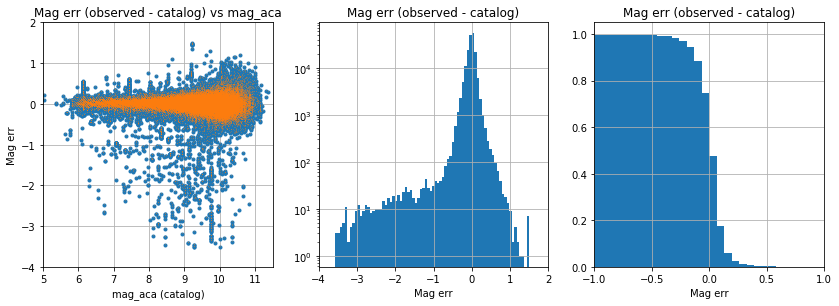

In [19]:
plot_mag_errs(acqs, red_mag_err=False)

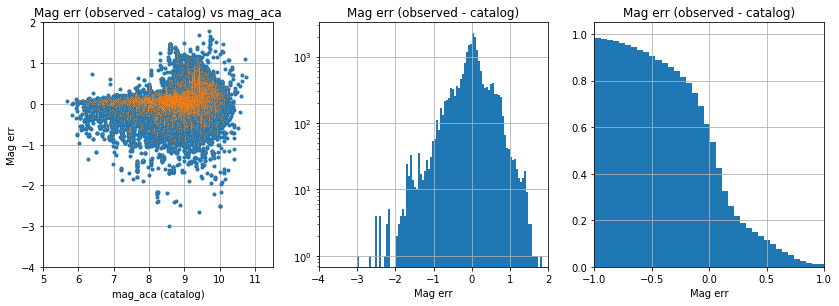

In [20]:
plot_mag_errs(acqs, red_mag_err=True)

## Model definition

In [21]:
spline_mags = np.array([8.0, 9.0, 10.0, 10.4, 10.7])

def t_ccd_normed(t_ccd):
    return (t_ccd + 8.0) / 8.0

def p_fail(pars, mag,
           t_ccd, tc2=None,
           box_delta=0, rescale=True):
    """
    Acquisition probability model
    """
    tc = t_ccd_normed(t_ccd) if rescale else t_ccd
    
    if tc2 is None:
        tc2 = tc ** 2
    
    # Make sure box_delta has right dimensions
    mag, tc, box_delta = np.broadcast_arrays(mag, tc, box_delta)

    p0s, p1s, p2s = pars[0:5], pars[5:10], pars[10:15]
    max_mag = 11.0
    p0 = CubicSpline(spline_mags, p0s, bc_type=((1, 0.0), (2, 0.0)))(mag.clip(8.0, max_mag))
    p1 = CubicSpline(spline_mags, p1s, bc_type=((1, 0.0), (2, 0.0)))(mag.clip(8.0, max_mag))
    p2 = CubicSpline(spline_mags, p2s, bc_type=((1, 0.0), (2, 0.0)))(mag.clip(8.0, max_mag))

    # Linear increase in probit_p_fail (3 per mag) after max_mag.  In normal range
    # this is always 0.0, but useful for color=1.5 star computations etc.
    faint_delta = (mag.clip(max_mag, None) - max_mag) * 3
    probit_p_fail = p0 + p1 * tc + p2 * tc2 + box_delta + faint_delta
    p_fail = stats.norm.cdf(probit_p_fail)  # transform from probit to linear probability

    return p_fail

def p_acq_fail(data=None):
    """
    Sherpa fit function wrapper to ensure proper use of data in fitting.
    """
    if data is None:
        data = data_all
        
    tc = t_ccd_normed(data['t_ccd'])
    tc2 = tc ** 2
    box_delta = data['box_delta']
    mag = data['mag_aca']
    
    def sherpa_func(pars, x=None):
        return p_fail(pars, mag, tc, tc2, box_delta, rescale=False)

    return sherpa_func

In [22]:
def calc_binom_stat(data, model, staterror=None, syserror=None, weight=None, bkg=None):
    """
    Calculate log-likelihood for a binomial probability distribution
    for a single trial at each point.
    
    Defining p = model, then probability of seeing data == 1 is p and
    probability of seeing data == 0 is (1 - p).  Note here that ``data``
    is strictly either 0.0 or 1.0, and np.where interprets those float
    values as False or True respectively.
    """
    fit_stat = -np.sum(np.log(np.where(data, model, 1.0 - model)))
    return fit_stat, np.ones(1)

In [23]:
def fit_poly_spline_model(data, parvals=None):
    from sherpa import ui

    # data = data_all if data_mask is None else data_all[data_mask]

    comp_names = [f'p{i}{j}' for i in range(3) for j in range(5)]
    
    # Approx starting values based on plot of p0, p1, p2
    # spline_mags = np.array([8.5, 9.25, 10.0, 10.5, 11.0])
    spline_p = {}
    if parvals:
        spline_p[0] = parvals[0:5]
        spline_p[1] = parvals[5:10]
        spline_p[2] = parvals[10:15]
    else:
        # From fit_acq_prob_model-2018-11-binned-poly-tccd.ipynb
        spline_p[0] = np.array([-2.375, -1.663, -0.271, 0.968, 1.527])
        spline_p[1] = np.array([0.689, 1.047, 2.177, 2.087, 1.225])
        spline_p[2] = np.array([0.559, 0.537, 0.706, -0.333, -0.629])
   
    data_id = 1
    
    ones = np.ones(len(data))
    ui.load_user_stat('binom_stat', calc_binom_stat, lambda x: ones)
    ui.set_stat(binom_stat)
    
    ui.set_method('simplex')
    ui.load_user_model(p_acq_fail(data), 'model')
    ui.add_user_pars('model', comp_names)
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data['year']), np.array(data['fail'], dtype=np.float))

    # Initial fit values from fit of all data
    fmod = ui.get_model_component('model')
    for i in range(3):
        for j in range(5):
            comp_name = f'p{i}{j}'
            setattr(fmod, comp_name, spline_p[i][j])
            comp = getattr(fmod, comp_name)
            comp.max = 10
            comp.min = -10.0 # if i == 0 else 0.0
            
    ui.fit(data_id)
    # conf = ui.get_confidence_results()
    return ui.get_fit_results()

## Plotting and validation

In [24]:
def plot_fit_grouped(pars, group_col, group_bin, mask=None, log=False, colors='br', label=None, probit=False):
    data = data_all if mask is None else data_all[mask]
    data['model'] = p_acq_fail(data)(pars)

    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    data_fail = data_mean['fail']
    model_fail = np.array(data_mean['model'])
    
    fail_sigmas = np.sqrt(data_fail * len_groups) / len_groups
    
    # Possibly plot the data and model probabilities in probit space
    if probit:
        dp = stats.norm.ppf(np.clip(data_fail + fail_sigmas, 1e-6, 1-1e-6))
        dm = stats.norm.ppf(np.clip(data_fail - fail_sigmas, 1e-6, 1-1e-6))
        data_fail = stats.norm.ppf(data_fail)
        model_fail = stats.norm.ppf(model_fail)
        fail_sigmas = np.vstack([data_fail - dm, dp - data_fail])
            
#    plt.errorbar(data_mean[group_col], data_fail, yerr=fail_sigmas, 
#                 fmt='.' + colors[1:], label=label, markersize=8)
#    plt.plot(data_mean[group_col], model_fail, '-' + colors[0])
    line, = plt.plot(data_mean[group_col], model_fail, '-')
    plt.errorbar(data_mean[group_col], data_fail, yerr=fail_sigmas, 
                        fmt='.', color=line.get_color(), label=label, markersize=8)
    
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [25]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag_aca'] > mag0) & (data_all['mag_aca'] < mag1)
    return ok

In [26]:
def t_ccd_filter(t_ccd0, t_ccd1):
    ok = (data_all['t_ccd'] > t_ccd0) & (data_all['t_ccd'] < t_ccd1)
    return ok

In [27]:
def plot_fit_all(parvals, mask=None, probit=False):
    if mask is None:
        mask = np.ones(len(data_all), dtype=bool)
     
    mt = mag_filter(8.5, 10.8) & mask
    plt.figure(figsize=(12, 4))
    for probit in True, False:
        plt.subplot(1, 2, int(probit) + 1)
        for v0, v1, colors in ((-11, -10, 'br'), 
                               (-12, -11, 'gk'), 
                               (-13, -12, 'cm'), 
                               (-14, -13, 'br'), 
                               (-15, -14, 'gk')):
            plot_fit_grouped(parvals, 'mag_aca', 0.25, t_ccd_filter(v0, v1) & mt,
                             colors=colors, label=f'{v0} < t_ccd < {v1}', probit=probit)
        plt.legend(loc='upper left')
        plt.ylim(-3, 3) if probit else plt.ylim(-0.1, 1.1)
        plt.ylabel('p_fail')
        plt.xlabel('year')
        plt.tight_layout()
        plt.grid()
    
    
    mt = t_ccd_filter(-16, -2) & mask
    plt.figure(figsize=(12, 4))
    for probit in True, False:
        plt.subplot(1, 2, int(probit) + 1)
        for v0, v1, colors in ((10.3, 10.7, 'gk'), 
                               (10, 10.3, 'cm'), 
                               (9.5, 10, 'br'), 
                               (9, 9.5, 'gk')):
            plot_fit_grouped(parvals, 'year', 0.25, mag_filter(v0, v1) & mt,
                             colors=colors, label=f'{v0} < mag < {v1}', probit=probit)
        plt.legend(loc='upper left')
        plt.ylim(-3, 3) if probit else plt.ylim(-0.1, 1.1)
        plt.ylabel('p_fail')
        plt.xlabel('mag_aca')
        plt.tight_layout()
        plt.grid()
    
    mt = t_ccd_filter(-16, -2) & mask
    plt.figure(figsize=(12, 4))
    for probit in True, False:
        plt.subplot(1, 2, int(probit) + 1)
        for v0, v1, colors in ((10.3, 10.7, 'gk'), 
                               (10, 10.3, 'cm'), 
                               (9.5, 10, 'br'), 
                               (9, 9.5, 'gk')):
            plot_fit_grouped(parvals, 't_ccd', 0.5, mag_filter(v0, v1) & mt,  
                             colors=colors, label=f'{v0} < mag < {v1}', probit=probit)
        plt.legend(loc='upper left')
        plt.ylim(-3, 3) if probit else plt.ylim(-0.1, 1.1)
        plt.xlabel('t_ccd')
        plt.ylabel('p_fail')
        plt.tight_layout()
        plt.grid()

In [28]:
def plot_splines(pars):
    mag = np.linspace(8.0, 11.0, 50)
    n = len(spline_mags)
    p0 = CubicSpline(spline_mags, pars[0:n], bc_type=((1, 0.0), (2, 0.0)))(mag.clip(8.0, None))
    p1 = CubicSpline(spline_mags, pars[n:2*n], bc_type=((1, 0.0), (2, 0.0)))(mag.clip(8.0, None))
    p2 = CubicSpline(spline_mags, pars[2*n:3*n], bc_type=((1, 0.0), (2, 0.0)))(mag.clip(8.0, None))
    plt.plot(mag, p0, label='p0')
    plt.plot(mag, p1, label='p1')
    plt.plot(mag, p2, label='p2')
    plt.grid()
    plt.legend();


In [29]:
def print_model_coeffs(parvals):
    n = len(spline_mags)
    print(f'spline_mags = np.array({spline_mags.tolist()})')
    ln = 'spline_vals = np.array(['
    print(ln, end='')
    print(', '.join(f'{val:.4f}' for val in parvals[0:n]) + ',')
    print(' ' * len(ln) + ', '.join(f'{val:.4f}' for val in parvals[n:2*n]) + ',')
    print(' ' * len(ln) + ', '.join(f'{val:.4f}' for val in parvals[2*n:3*n]) + '])')

## Color != 1.5 fit (this is MOST acq stars)

In [30]:
mask_no_1p5 = ~data_all['red_mag_err']

In [31]:
fit_no_1p5 = fit_poly_spline_model(data_all[mask_no_1p5])

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'
Dataset               = 1
Method                = neldermead
Statistic             = binom_stat
Initial fit statistic = 11664.8
Final fit statistic   = 11337.7 at function evaluation 3535
Data points           = 59515
Degrees of freedom    = 59500
Change in statistic   = 327.137
   model.p00      -2.96268    
   model.p01      -1.9569     
   model.p02      -0.182764   
   model.p03      1.2524      
   model.p04      1.89333     
   model.p10      0.508371    
   model.p11      0.807424    
   model.p12      1.89124     
   model.p13      1.9192      
   model.p14      1.48747     
   model.p20      1.02751     
   model.p21      0.251629    
   model.p22      0.311353    
   model.p23      -0.925113   
   model.p24      -0.88826    


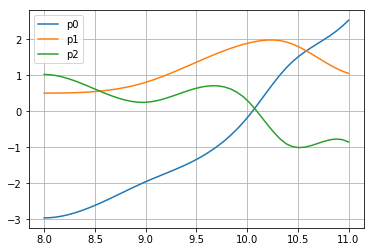

In [32]:
plot_splines(fit_no_1p5.parvals)

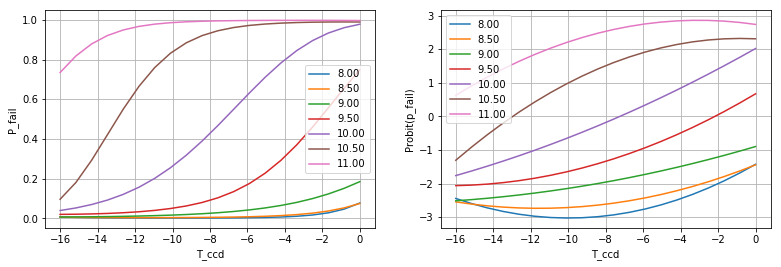

In [33]:
colors = [f'kC{i}' for i in range(9)]

# This computes probabilities for 120 arcsec boxes, corresponding to raw data
t_ccds = np.linspace(-16, -0, 20)
plt.figure(figsize=(13, 4))

for subplot in (1, 2):
    plt.subplot(1, 2, subplot)
    for mag, color in zip(np.linspace(8.0, 11.0, 7), colors):
        probs = p_fail(fit_no_1p5.parvals, mag, t_ccds)
        if subplot == 2:
            probs = stats.norm.ppf(probs)
        plt.plot(t_ccds, probs, label=f'{mag:.2f}')

    plt.legend()
    plt.xlabel('T_ccd')
    plt.ylabel('P_fail' if subplot == 1 else 'Probit(p_fail)')
    plt.grid()

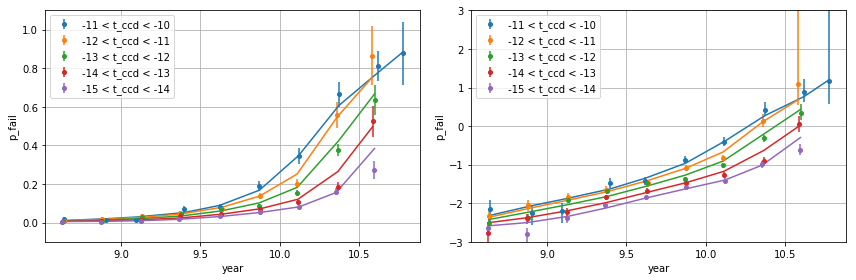

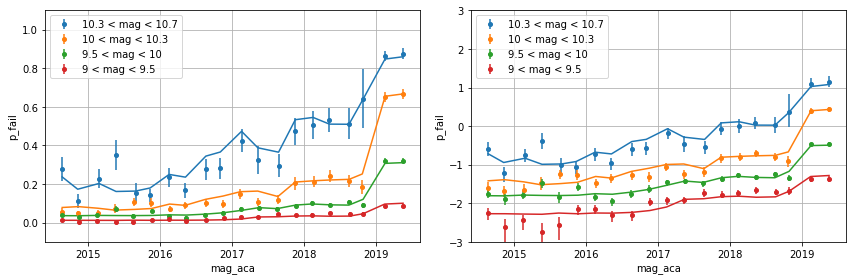

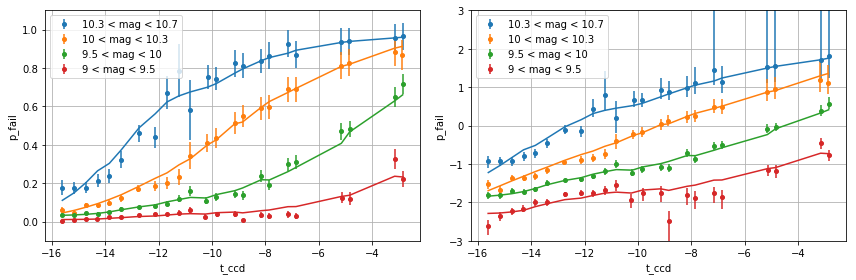

In [34]:
plot_fit_all(fit_no_1p5.parvals, mask_no_1p5)

### Focus on 10.3 to 10.6 mag bin for recent times

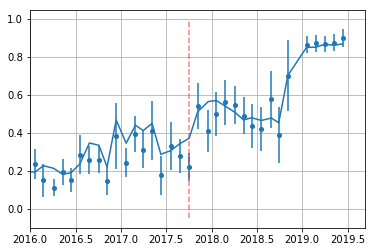

In [35]:
plot_fit_grouped(fit_no_1p5.parvals, 'year', 0.10, mag_filter(10.3, 10.6) & mask_no_1p5,  
                 colors='gk', label='10.3 < mag < 10.6')
plt.xlim(2016.0, None)
y0, y1 = plt.ylim()
x = DateTime('2017-10-01T00:00:00').frac_year
plt.plot([x, x], [y0, y1], '--r', alpha=0.5)
plt.grid();

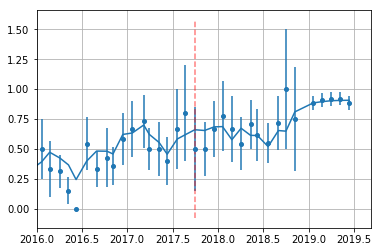

In [36]:
plot_fit_grouped(fit_no_1p5.parvals, 'year', 0.10, mag_filter(10.5, 10.7) & mask_no_1p5,  
                 colors='gk', label='10.5 < mag < 10.7')
plt.xlim(2016.0, None)
y0, y1 = plt.ylim()
x = DateTime('2017-10-01T00:00:00').frac_year
plt.plot([x, x], [y0, y1], '--r', alpha=0.5)
plt.grid();

### Focus on 10.0 to 10.3 mag bin for recent times

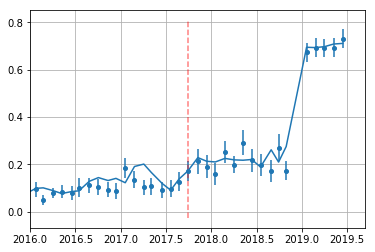

In [37]:
plot_fit_grouped(fit_no_1p5.parvals, 'year', 0.10, mag_filter(10.0, 10.3) & mask_no_1p5,  
                 colors='gk', label='10.0 < mag < 10.3')
plt.xlim(2016.0, None)
y0, y1 = plt.ylim()
x = DateTime('2017-10-01T00:00:00').frac_year
plt.plot([x, x], [y0, y1], '--r', alpha=0.5)
plt.grid();

### Histogram of warm pixel fraction

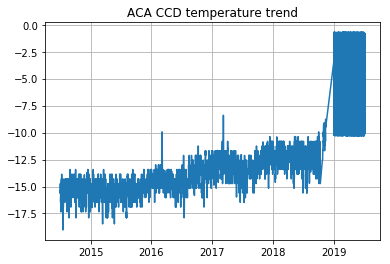

In [38]:
plt.plot(data_all['year'], data_all['t_ccd'])
plt.title('ACA CCD temperature trend')
plt.grid();

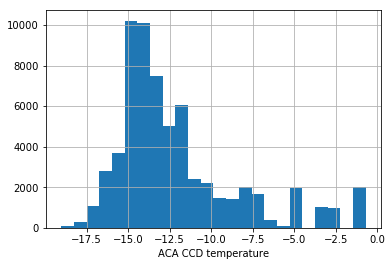

In [39]:
plt.hist(data_all['t_ccd'], bins=24)
plt.grid()
plt.xlabel('ACA CCD temperature');

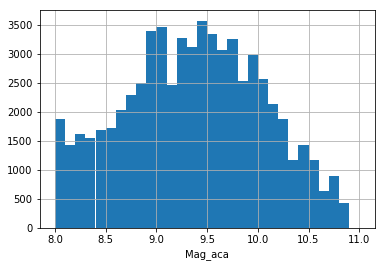

In [40]:
plt.hist(data_all['mag_aca'], bins=np.arange(8.0, 11.1, 0.1))
plt.grid()
plt.xlabel('Mag_aca');

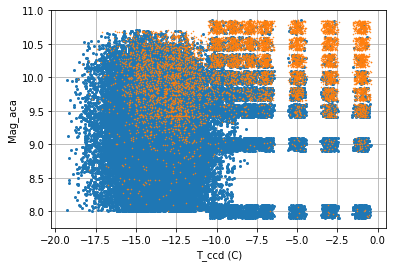

In [41]:
da = data_all
ok = ~da['fail'].astype(bool)
fuzz = np.random.uniform(-0.3, 0.3, np.count_nonzero(ok))
plt.plot(da['t_ccd'][ok] + fuzz, da['mag_aca'][ok], '.C0', markersize=4)

ok = da['fail'].astype(bool)
fuzz = np.random.uniform(-0.3, 0.3, np.count_nonzero(ok))
plt.plot(da['t_ccd'][ok] + fuzz, da['mag_aca'][ok], '.C1', ms=1)
plt.xlabel('T_ccd (C)')
plt.ylabel('Mag_aca')
plt.grid()

## Compare with Apr-2018 flight model and recent flight data


In [42]:
from scipy.stats import binom

def calc_binned_pfail(data_all, mag, dmag, t_ccd, dt):
    da = data_all[~data_all['asvt'] & (data_all['halfwidth'] == 120)]
    fail = da['fail'].astype(bool)
    ok = (np.abs(da['mag_aca'] - mag) < dmag) & (np.abs(da['t_ccd'] - t_ccd) < dt)
    n_fail = np.count_nonzero(fail[ok])
    n_acq = np.count_nonzero(ok)
    p_fail = n_fail / n_acq
    p_fail_lower = binom.ppf(0.17, n_acq, n_fail / n_acq) / n_acq
    p_fail_upper = binom.ppf(0.84, n_acq, n_fail / n_acq) / n_acq
    mean_t_ccd = np.mean(da['t_ccd'][ok])
    mean_mag = np.mean(da['mag_aca'][ok])
    return p_fail, p_fail_lower, p_fail_upper, mean_t_ccd, mean_mag, n_fail, n_acq

In [43]:
pfs_list = []
for mag in (10.0, 10.3, 10.55):
    pfs = []
    for t_ccd in np.linspace(-15, -11, 5):
        pf = calc_binned_pfail(data_all, mag, 0.2, t_ccd, 0.5)
        pfs.append(pf)
        print(f'mag={mag} mean_mag_aca={pf[4]:.2f} t_ccd=f{pf[3]:.2f} p_fail={pf[-2]}/{pf[-1]}={pf[0]:.2f}')
    pfs_list.append(pfs)

mag=10.0 mean_mag_aca=10.00 t_ccd=f-14.92 p_fail=82/1345=0.06
mag=10.0 mean_mag_aca=10.00 t_ccd=f-14.09 p_fail=94/1319=0.07
mag=10.0 mean_mag_aca=10.01 t_ccd=f-13.00 p_fail=121/1250=0.10
mag=10.0 mean_mag_aca=10.02 t_ccd=f-11.94 p_fail=80/622=0.13
mag=10.0 mean_mag_aca=10.04 t_ccd=f-11.09 p_fail=49/243=0.20
mag=10.3 mean_mag_aca=10.25 t_ccd=f-14.92 p_fail=91/843=0.11
mag=10.3 mean_mag_aca=10.25 t_ccd=f-14.09 p_fail=96/779=0.12
mag=10.3 mean_mag_aca=10.26 t_ccd=f-13.01 p_fail=161/747=0.22
mag=10.3 mean_mag_aca=10.26 t_ccd=f-11.94 p_fail=135/406=0.33
mag=10.3 mean_mag_aca=10.25 t_ccd=f-11.11 p_fail=57/136=0.42
mag=10.55 mean_mag_aca=10.48 t_ccd=f-14.93 p_fail=56/275=0.20
mag=10.55 mean_mag_aca=10.48 t_ccd=f-14.08 p_fail=64/254=0.25
mag=10.55 mean_mag_aca=10.48 t_ccd=f-12.99 p_fail=122/276=0.44
mag=10.55 mean_mag_aca=10.48 t_ccd=f-11.96 p_fail=87/163=0.53
mag=10.55 mean_mag_aca=10.46 t_ccd=f-11.09 p_fail=31/43=0.72


In [44]:
from chandra_aca.star_probs import acq_success_prob

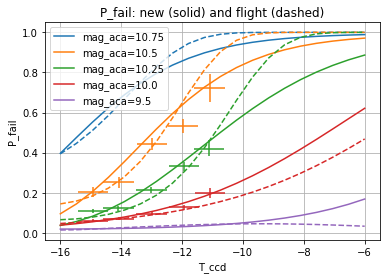

In [45]:
# This computes probabilities for 120 arcsec boxes, corresponding to raw data
t_ccds = np.linspace(-16, -6, 20)
mag_acas = np.array([9.5, 10.0, 10.25, 10.5, 10.75])

for ii, mag_aca in enumerate(reversed(mag_acas)):
    flight_probs = 1 - acq_success_prob(date='2018-05-01T00:00:00', t_ccd=t_ccds, mag=mag_aca)
    new_probs = p_fail(fit_no_1p5.parvals, mag_aca, t_ccds)
    plt.plot(t_ccds, flight_probs, '--', color=f'C{ii}')
    plt.plot(t_ccds, new_probs, '-', color=f'C{ii}', label=f'mag_aca={mag_aca}')

# pf1, pf2 have p_fail, p_fail_lower, p_fail_upper, mean_t_ccd, mean_mag_aca, n_fail, n_acq
for pfs, color in zip(pfs_list, ('C3', 'C2', 'C1')):
    for pf in pfs:
        yerr = np.array([pf[0] - pf[1], pf[2] - pf[0]]).reshape(2, 1)
        plt.errorbar(pf[3], pf[0], xerr=0.5, yerr=yerr, color=color)

# plt.xlim(-16, None)
plt.legend()
plt.xlabel('T_ccd')
plt.ylabel('P_fail')
plt.title('P_fail: new (solid) and flight (dashed)')
plt.grid()

## Color == 1.5 fit

In [46]:
np.count_nonzero(data_all0['red_mag_err'])

4822

In [47]:
ok = ((acqs['red_mag_err'] == True) & 
      (acqs['mag_obs'] > 0) & 
      (acqs['img_func'] == 'star'))
red_mag_err_sample = acqs['mag_obs'][ok] - acqs['mag_aca'][ok]

In [48]:
n_sim = 30000
nd = Table()
nd['year'] = np.random.uniform(2014.5, 2019.0, size=n_sim)
nd['mag_aca'] = np.random.uniform(8.5, 11, size=n_sim)
nd['t_ccd'] = np.random.uniform(-16, -2, size=n_sim)
nd['halfwidth'] = np.random.choice([60, 80, 100, 120, 140, 160, 180], size=n_sim)
nd['quarter'] = (np.trunc((nd['year'] - year_q0) * 4)).astype('f4')
nd['color'] = 1.5
nd['asvt'] = True
nd['red_mag_err'] = True
nd['mag_obs'] = nd['mag_aca'] + np.random.choice(red_mag_err_sample, size=n_sim)

In [49]:
b1 = 0.96
b2 = -0.30
box0 = (nd['halfwidth'] - 120) / 120  # normalized version of box, equal to 0.0 at nominal default
nd['box_delta'] = b1 * box0 + b2 * box0**2

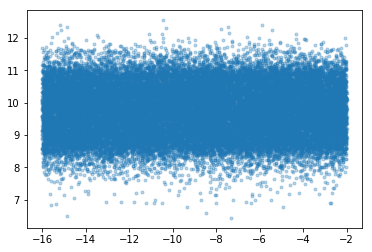

In [50]:
plt.plot(nd['t_ccd'], nd['mag_obs'], '.', alpha=0.3)

In [51]:
nd['p_fail'] = p_fail(fit_no_1p5.parvals, nd['mag_obs'], nd['t_ccd'], box_delta=nd['box_delta'])
nd['fail'] = (np.random.uniform(0.0, 1.0, size=n_sim) < nd['p_fail']).astype(np.float64)
nd['fail'][nd['mag_obs'] > 11] = 1

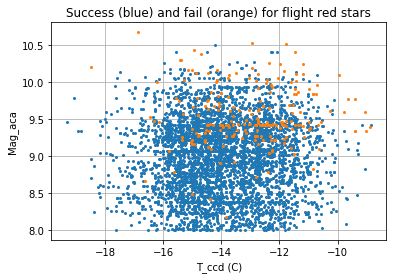

In [52]:
da = data_all[data_all['red_mag_err'] & ~data_all['asvt']]
ok = ~da['fail'].astype(bool)
fuzz = np.random.uniform(-0.3, 0.3, np.count_nonzero(ok))
plt.plot(da['t_ccd'][ok] + fuzz, da['mag_aca'][ok], '.C0', markersize=4)

ok = da['fail'].astype(bool)
fuzz = np.random.uniform(-0.3, 0.3, np.count_nonzero(ok))
plt.plot(da['t_ccd'][ok] + fuzz, da['mag_aca'][ok], '.C1', ms=4)
plt.xlabel('T_ccd (C)')
plt.ylabel('Mag_aca')
plt.grid()
plt.title('Success (blue) and fail (orange) for flight red stars');

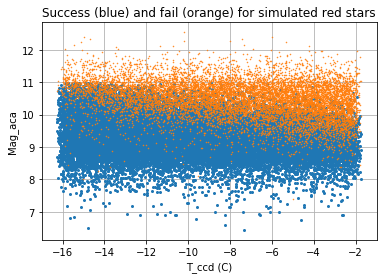

In [53]:
da = nd
ok = ~da['fail'].astype(bool)
fuzz = np.random.uniform(-0.3, 0.3, np.count_nonzero(ok))
plt.plot(da['t_ccd'][ok] + fuzz, da['mag_obs'][ok], '.C0', markersize=4)

ok = da['fail'].astype(bool)
fuzz = np.random.uniform(-0.3, 0.3, np.count_nonzero(ok))
plt.plot(da['t_ccd'][ok] + fuzz, da['mag_obs'][ok], '.C1', ms=1)
plt.xlabel('T_ccd (C)')
plt.ylabel('Mag_aca')
plt.grid()
plt.title('Success (blue) and fail (orange) for simulated red stars');

In [54]:
data_all = vstack([data_all0, nd]).group_by('quarter')

In [55]:
mask_1p5 = data_all['red_mag_err'] & data_all['asvt']
fit_1p5 = fit_poly_spline_model(data_all[mask_1p5], fit_no_1p5.parvals)  # data_all[mask_1p5])

Dataset               = 1
Method                = neldermead
Statistic             = binom_stat
Initial fit statistic = 11415
Final fit statistic   = 10946.6 at function evaluation 3521
Data points           = 30000
Degrees of freedom    = 29985
Change in statistic   = 468.334
   model.p00      -2.35452    
   model.p01      -1.72806    
   model.p02      -0.0409395  
   model.p03      0.802774    
   model.p04      1.4173      
   model.p10      0.857739    
   model.p11      0.874335    
   model.p12      1.3717      
   model.p13      1.33791     
   model.p14      1.14521     
   model.p20      -0.21597    
   model.p21      0.251259    
   model.p22      -0.0613653  
   model.p23      -0.330282   
   model.p24      -0.518521   


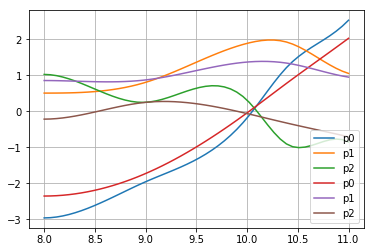

In [56]:
plot_splines(fit_no_1p5.parvals)
plot_splines(fit_1p5.parvals)
plt.grid()

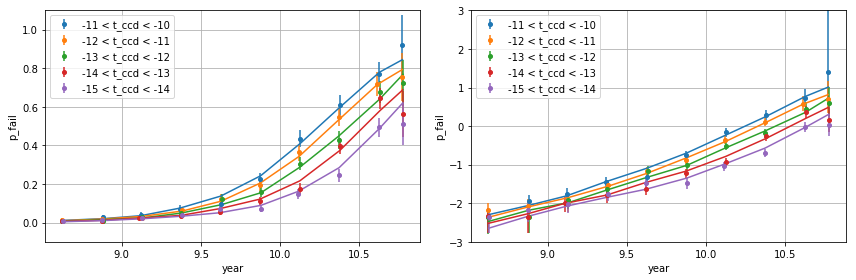

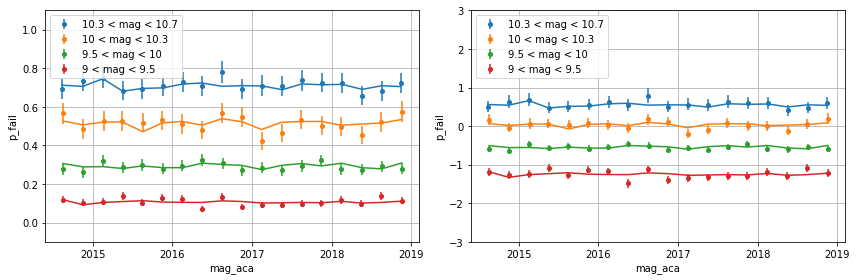

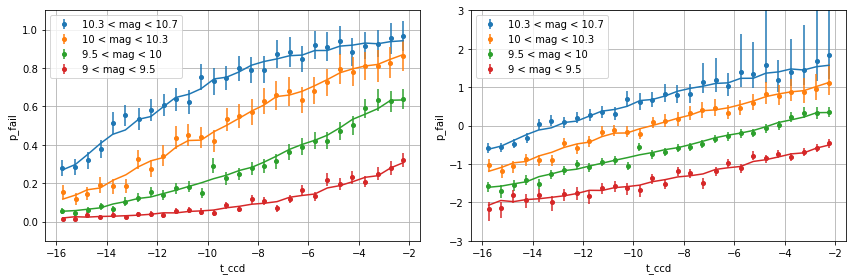

In [57]:
plot_fit_all(fit_1p5.parvals, mask=data_all['red_mag_err'] & data_all['asvt'])

## Final fit values for `chandra_aca.star_probs`

In [58]:
def print_parvals(parvals, label):
    print('{:s} = np.array([{:s},  # P0 values'
          .format(label, ', '.join(str(round(x, 5)) for x in parvals[0:5])))
    print(' ' * len(label) + '             {:s},  # P1 values'
          .format(', '.join(str(round(x, 5)) for x in parvals[5:10])))
    print(' ' * len(label) + '             {:s}])  # P2 values'
          .format(', '.join(str(round(x, 5)) for x in parvals[10:15])))

In [59]:
print_parvals(fit_no_1p5.parvals, 'fit_no_1p5')

fit_no_1p5 = np.array([-2.96268, -1.9569, -0.18276, 1.2524, 1.89333,  # P0 values
                       0.50837, 0.80742, 1.89124, 1.9192, 1.48747,  # P1 values
                       1.02751, 0.25163, 0.31135, -0.92511, -0.88826])  # P2 values


In [60]:
print_parvals(fit_1p5.parvals, 'fit_1p5')

fit_1p5 = np.array([-2.35452, -1.72806, -0.04094, 0.80277, 1.4173,  # P0 values
                    0.85774, 0.87433, 1.3717, 1.33791, 1.14521,  # P1 values
                    -0.21597, 0.25126, -0.06137, -0.33028, -0.51852])  # P2 values


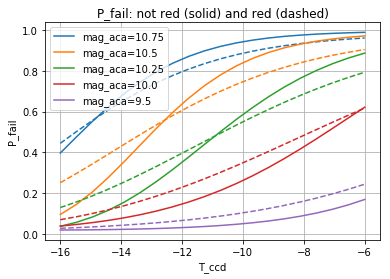

In [61]:
# This computes probabilities for 120 arcsec boxes, corresponding to raw data
t_ccds = np.linspace(-16, -6, 20)
mag_acas = np.array([9.5, 10.0, 10.25, 10.5, 10.75])

for ii, mag_aca in enumerate(reversed(mag_acas)):
    red_probs = p_fail(fit_1p5.parvals, mag_aca, t_ccds)
    not_red_probs = p_fail(fit_no_1p5.parvals, mag_aca, t_ccds)
    plt.plot(t_ccds, red_probs, '--', color=f'C{ii}')
    plt.plot(t_ccds, not_red_probs, '-', color=f'C{ii}', label=f'mag_aca={mag_aca}')

# plt.xlim(-16, None)
plt.legend()
plt.xlabel('T_ccd')
plt.ylabel('P_fail')
plt.title('P_fail: not red (solid) and red (dashed)')
plt.grid()

In [62]:
def plot_sim_p_fail_dist(mag_aca, t_ccd, n_sim=1000):
    nom_p_fail = p_fail(fit_no_1p5.parvals, mag_aca, t_ccd)
    mag_obs = mag_aca + np.random.choice(red_mag_err_sample, size=n_sim)
    sim_p_fails = p_fail(fit_no_1p5.parvals, mag_obs, t_ccd)
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.hist(sim_p_fails, bins=50)
    plt.vlines([nom_p_fail, sim_p_fails.mean()], *plt.ylim(), colors=['k', 'r'])
    plt.grid()
    
    plt.subplot(1, 2, 2)
    fuzz = np.random.uniform(-0.1, 0.1, size=len(sim_p_fails))
    plt.plot(mag_obs, sim_p_fails + fuzz, '.', alpha=0.5)
    plt.grid()

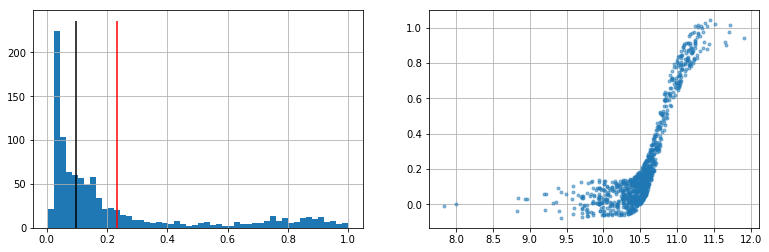

In [63]:
plot_sim_p_fail_dist(mag_aca=10.5, t_ccd=-16)

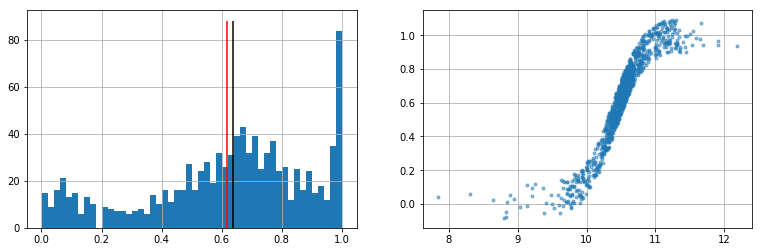

In [64]:
plot_sim_p_fail_dist(mag_aca=10.5, t_ccd=-12)

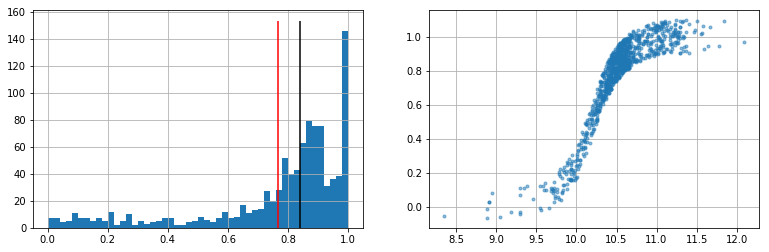

In [65]:
plot_sim_p_fail_dist(mag_aca=10.5, t_ccd=-10)